# Importaciones de librerias y datos necesarios

In [35]:
import os
import numpy as np
import pandas as pd
import zipfile
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

## Importación opcional de los datos de la competencia en Kaggle

In [36]:
os.environ['KAGGLE_CONFIG_DIR'] = './kaggle-config'
!kaggle competitions download -c udea-ai4eng-20241

udea-ai4eng-20241.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extraer datos de los archivos de Kaggle

In [37]:
path = "udea-ai4eng-20241.zip"
directory = "data/"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(directory)

# Visualizar dataframe con los datos de la competencia

In [38]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df.head(5)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo


In [39]:
df.dtypes

ID                                 int64
PERIODO                            int64
ESTU_PRGM_ACADEMICO               object
ESTU_PRGM_DEPARTAMENTO            object
ESTU_VALORMATRICULAUNIVERSIDAD    object
ESTU_HORASSEMANATRABAJA           object
FAMI_ESTRATOVIVIENDA              object
FAMI_TIENEINTERNET                object
FAMI_EDUCACIONPADRE               object
FAMI_TIENELAVADORA                object
FAMI_TIENEAUTOMOVIL               object
ESTU_PRIVADO_LIBERTAD             object
ESTU_PAGOMATRICULAPROPIO          object
FAMI_TIENECOMPUTADOR              object
FAMI_TIENEINTERNET.1              object
FAMI_EDUCACIONMADRE               object
RENDIMIENTO_GLOBAL                object
dtype: object

## Se visualizan los datos faltantes

In [40]:
def show_missing_values(df):
    plt.figure(figsize=(10,6))
    sns.displot(
        data=df.isna().melt(value_name="Faltantes"),
        y="variable",
        hue="Faltantes",
        multiple="fill",
        aspect=1.25
    )

<Figure size 1000x600 with 0 Axes>

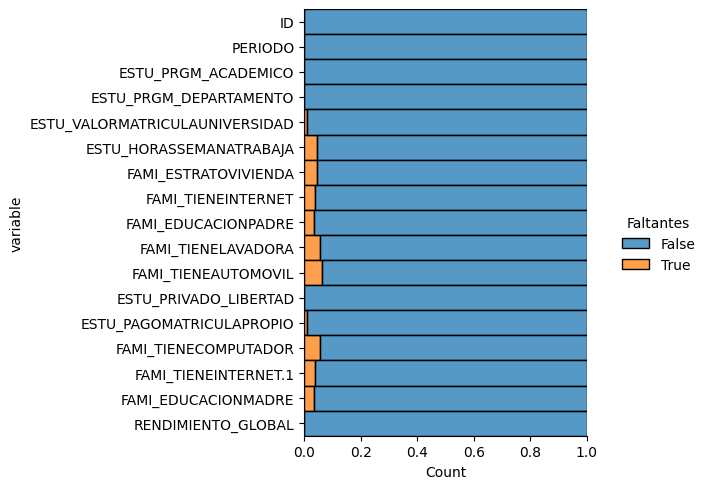

In [41]:
show_missing_values(df)

# Limpieza de los valores en la columna ESTU_PRGM_ACADEMICO 

In [42]:
def normalize_string(s):
    return (
        unicodedata.normalize('NFKD', s)
        .encode('ascii', errors='ignore')
        .decode('utf-8')
        .lower()
        .strip()
        .replace('  ', ' ')
    )

df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(normalize_string)
df_test['ESTU_PRGM_ACADEMICO'] = df_test['ESTU_PRGM_ACADEMICO'].apply(normalize_string)

In [43]:
df['ESTU_PRGM_ACADEMICO'].value_counts().to_dict()

{'administracion de empresas': 76679,
 'derecho': 53244,
 'contaduria publica': 51846,
 'psicologia': 49309,
 'ingenieria industrial': 34794,
 'ingenieria civil': 21315,
 'medicina': 18099,
 'ingenieria de sistemas': 18028,
 'licenciatura en pedagogia infantil': 14850,
 'ingenieria ambiental': 13130,
 'trabajo social': 12686,
 'enfermeria': 12186,
 'arquitectura': 11469,
 'administracion en salud ocupacional': 11018,
 'negocios internacionales': 8858,
 'economia': 7515,
 'ingenieria mecanica': 7271,
 'ingenieria electronica': 6804,
 'administracion financiera': 6412,
 'comunicacion social': 6351,
 'fisioterapia': 5992,
 'odontologia': 5272,
 'administracion publica territorial': 5002,
 'administracion de negocios internacionales': 4962,
 'ingenieria quimica': 4142,
 'diseno grafico': 3919,
 'comunicacion social- periodismo': 3512,
 'biologia': 3153,
 'ingenieria electrica': 3019,
 'medicina veterinaria y zootecnia': 2865,
 'ingenieria mecatronica': 2754,
 'diseno industrial': 2697,
 'm

In [44]:
def extraer_primera_palabra(texto):
    palabra = texto.replace('3','')
    palabra = palabra.split()[0]
    palabra= palabra.replace('-','')
    return palabra

df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)
df_test['ESTU_PRGM_ACADEMICO'] = df_test['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)

In [45]:
df['ESTU_PRGM_ACADEMICO'].value_counts().to_dict()

{'ingenieria': 147722,
 'administracion': 126816,
 'licenciatura': 66280,
 'derecho': 53696,
 'contaduria': 52298,
 'psicologia': 49309,
 'medicina': 23508,
 'comunicacion': 16779,
 'trabajo': 12686,
 'enfermeria': 12186,
 'arquitectura': 11469,
 'negocios': 9873,
 'profesional': 9754,
 'diseno': 9619,
 'economia': 7929,
 'fisioterapia': 5992,
 'odontologia': 5272,
 'mercadeo': 5132,
 'ciencias': 3595,
 'biologia': 3395,
 'finanzas': 2922,
 'comercio': 2867,
 'ciencia': 2529,
 'quimica': 2499,
 'publicidad': 2371,
 'artes': 2347,
 'nutricion': 2276,
 'salud': 2058,
 'relaciones': 1717,
 'zootecnia': 1669,
 'sociologia': 1616,
 'instrumentacion': 1610,
 'bacteriologia': 1530,
 'fonoaudiologia': 1503,
 'seguridad': 1467,
 'terapia': 1449,
 'musica': 1214,
 'lenguas': 1110,
 'microbiologia': 1097,
 'antropologia': 1060,
 'jurisprudencia': 1011,
 'filosofia': 930,
 'historia': 902,
 'cine': 899,
 'optometria': 896,
 'agronomia': 860,
 'matematicas': 779,
 'teologia': 747,
 'geologia': 725,

In [46]:
carreras = df['ESTU_PRGM_ACADEMICO'].unique()
carreras.sort()
carreras

array(['actividad', 'acuicultura', 'administracin', 'administracion',
       'adminsitracion', 'agronomia', 'animacion', 'antropologia',
       'archivistica', 'arqueologia', 'arquitectura', 'arte', 'artes',
       'astronomia', 'bacteriologia', 'banca', 'bellas',
       'bibliotecologia', 'bioingenieria', 'biologia', 'bioquimica',
       'biotecnologia', 'ciclo', 'ciencia', 'ciencias', 'cine',
       'comercio', 'computacion', 'comunicacin', 'comunicacion',
       'comunicaciones', 'conservacion', 'construccion', 'construcciones',
       'contaduria', 'creacion', 'criminalistica', 'culinaria', 'cultura',
       'danza', 'deporte', 'derecho', 'desarrollo', 'direccion', 'diseno',
       'diseo', 'ecologia', 'economa', 'economia', 'enfermeria',
       'entrenamiento', 'espanol', 'estadistica', 'estudios', 'farmacia',
       'filologia', 'filosofia', 'finanzas', 'fisica', 'fisioterapia',
       'fonoaudiologia', 'formacion', 'fotografia', 'gastronomia',
       'geociencias', 'geografia', 

# Limpieza de columnas duplicadas

## FAMI_TIENEINTERNET

Mediante ``` df.dtypes ``` verificamos que tenemos 2 columnas que inician con 'FAMI_TIENEINTERNET', vamos validar si tiene los mismos datos.

In [47]:
(df['FAMI_TIENEINTERNET'] == df['FAMI_TIENEINTERNET.1']).value_counts()

True     665871
False     26629
Name: count, dtype: int64

In [48]:
np.nan == np.nan

False

In [49]:
df['FAMI_TIENEINTERNET.1'].isna().sum()

26629

In [50]:
df['FAMI_TIENEINTERNET.1'].isna().sum() == df['FAMI_TIENEINTERNET'].isna().sum()

True

Tenemos **26629** que no coinciden en la comparacion entre 'FAMI_TIENEINTERNET' y 'FAMI_TIENEINTERNET.1'. Esto se debe a que al comparar los datos nulos de las columnas ocurre la condicion ```np.nan == np.nan``` y es igual a ```False```, ademas, la cantidad de datos nulos en ambas columnas es **26629**. Por tanto se puede eliminar la comuna 'FAMI_TIENEINTERNET.1'.

In [51]:
df.drop(['FAMI_TIENEINTERNET.1'], axis = 1, inplace = True) #columna repetida
df_test.drop(['FAMI_TIENEINTERNET.1'], axis = 1, inplace = True) #columna repetida

# Limpieza de variables categoricas con valores nulos

A continuación realizaremos la limpieza de las variables ESTU_VALORMATRICULAUNIVERSIDAD, ESTU_HORASSEMANATRABAJA, FAMI_ESTRATOVIVIENDA, FAMI_TIENEINTERNET, FAMI_EDUCACIONPADRE, FAMI_TIENELAVADORA, FAMI_TIENEAUTOMOVIL, ESTU_PRIVADO_LIBERTAD, ESTU_PAGOMATRICULAPROPIO, FAMI_TIENECOMPUTADOR y FAMI_EDUCACIONMADRE.

In [52]:
categorical_columns = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
                            'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
                            'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_EDUCACIONMADRE']

In [53]:
def show_unique_values_by_columns(df, array_columns):
    for col in array_columns:
        print(f'{col} =', df[col].unique(),'\n')

In [54]:
show_unique_values_by_columns(df, categorical_columns)

ESTU_VALORMATRICULAUNIVERSIDAD = ['Entre 5.5 millones y menos de 7 millones'
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones' 'Más de 7 millones'
 'Entre 1 millón y menos de 2.5 millones'
 'Entre 500 mil y menos de 1 millón' 'Menos de 500 mil'
 'No pagó matrícula' nan] 

ESTU_HORASSEMANATRABAJA = ['Menos de 10 horas' '0' 'Más de 30 horas' 'Entre 21 y 30 horas'
 'Entre 11 y 20 horas' nan] 

FAMI_ESTRATOVIVIENDA = ['Estrato 3' 'Estrato 4' 'Estrato 5' 'Estrato 2' 'Estrato 1' nan
 'Estrato 6' 'Sin Estrato'] 

FAMI_TIENEINTERNET = ['Si' 'No' nan] 

FAMI_EDUCACIONPADRE = ['Técnica o tecnológica incompleta' 'Técnica o tecnológica completa'
 'Secundaria (Bachillerato) completa' 'No sabe' 'Primaria completa'
 'Educación profesional completa' 'Educación profesional incompleta'
 'Primaria incompleta' 'Postgrado' nan
 'Secundaria (Bachillerato) incompleta' 'Ninguno' 'No Aplica'] 

FAMI_TIENELAVADORA = ['Si' 'No' nan] 

FAMI_TIENEAUTOMOVIL = ['Si' 'No' nan] 



Método para llenar nulos con la moda de una columna

In [55]:
def fillna_with_mode(df, array_columns):
  for col in array_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

Método para llenar nulos con el valor de un atributo de una columna

In [56]:
def fillna_with_a_value(df, col, value):
    df[col] = df[col].fillna(value)

Método para remplazar un valor con un nuevo valor de una columna

In [57]:
def replace_value_in_a_column(df, col, to_replace, new_value):
    df[col] = df[col].replace(to_replace, new_value)

In [58]:
categorical_columns1 = categorical_columns.copy()
categorical_columns1.remove('FAMI_EDUCACIONPADRE')
categorical_columns1.remove('FAMI_EDUCACIONMADRE')

In [59]:
fillna_with_mode(df, categorical_columns1)
fillna_with_mode(df_test, categorical_columns1)

In [60]:
categorical_columns2 = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']

In [61]:
for col in categorical_columns2:
    fillna_with_a_value(df, col, 'No sabe')
    fillna_with_a_value(df_test, col, 'No sabe')

In [62]:
for col in categorical_columns2:
    replace_value_in_a_column(df, col, 'No Aplica', 'Ninguno')
    replace_value_in_a_column(df_test, col, 'No Aplica', 'Ninguno')

Verificar que no tengamos datos nulos

<Figure size 1000x600 with 0 Axes>

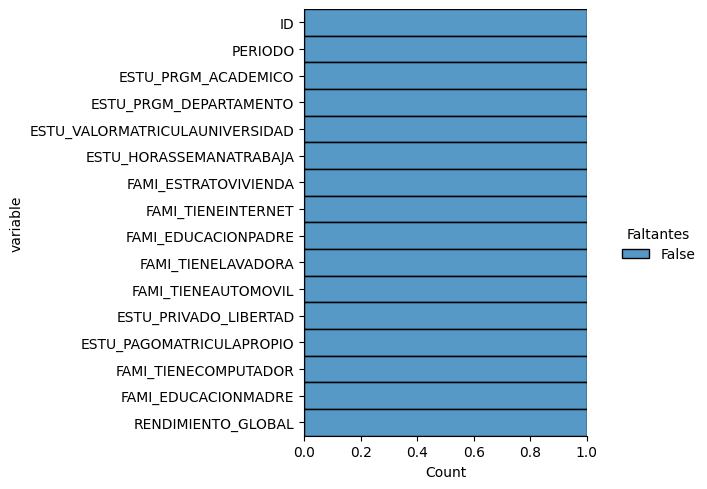

In [63]:
show_missing_values(df)

# Columna periodo de int a object

In [64]:
df['PERIODO'].unique()

array([20212, 20203, 20195, 20183, 20194, 20213, 20184, 20202, 20196],
      dtype=int64)

In [65]:
str_period = df['PERIODO'].astype(str)
df['PERIODO'] = str_period.str[:4] + '_' + str_period.str[4]

Estandarizamos la columna periodo añladiendo un "_" y como objeto y cambiarlo de int a obj

In [66]:
str_period_test = df_test['PERIODO'].astype(str)
df_test['PERIODO'] = str_period_test.str[:4] + '_' + str_period_test.str[4]

In [67]:
df.astype({'PERIODO': 'object'}).dtypes

ID                                 int64
PERIODO                           object
ESTU_PRGM_ACADEMICO               object
ESTU_PRGM_DEPARTAMENTO            object
ESTU_VALORMATRICULAUNIVERSIDAD    object
ESTU_HORASSEMANATRABAJA           object
FAMI_ESTRATOVIVIENDA              object
FAMI_TIENEINTERNET                object
FAMI_EDUCACIONPADRE               object
FAMI_TIENELAVADORA                object
FAMI_TIENEAUTOMOVIL               object
ESTU_PRIVADO_LIBERTAD             object
ESTU_PAGOMATRICULAPROPIO          object
FAMI_TIENECOMPUTADOR              object
FAMI_EDUCACIONMADRE               object
RENDIMIENTO_GLOBAL                object
dtype: object

# Mapear los valores de las columnas según las asignaciones proporcionadas

In [68]:

mapeo_valormatricula = {
    'No pagó matrícula': 1,
    'Menos de 500 mil': 2,
    'Entre 500 mil y menos de 1 millón': 3,
    'Entre 1 millón y menos de 2.5 millones': 4,
    'Entre 2.5 millones y menos de 4 millones': 5,
    'Entre 4 millones y menos de 5.5 millones': 6,
    'Entre 5.5 millones y menos de 7 millones': 7,
    'Más de 7 millones': 8
}

mapeo_horassemanatrabaja = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
}
mapeo_estratovivienda = {
    'Sin Estrato': 0,
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6
}

map_rendimiento_global = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}

df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valormatricula).astype('uint8')
df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].map(mapeo_horassemanatrabaja).astype('uint8')
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].map(mapeo_estratovivienda).astype('uint8')
df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_rendimiento_global).astype('uint8')

df_test['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_test['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valormatricula).astype('uint8')
df_test['ESTU_HORASSEMANATRABAJA'] = df_test['ESTU_HORASSEMANATRABAJA'].map(mapeo_horassemanatrabaja).astype('uint8')
df_test['FAMI_ESTRATOVIVIENDA'] = df_test['FAMI_ESTRATOVIVIENDA'].map(mapeo_estratovivienda).astype('uint8')

In [69]:
def set_integer_by_text(value, true_text):
  if value and value == true_text:
    return 1
  else: 
    return 0

Cambiar las variables de "Si" y "No" a 0 y 1

In [70]:
df['FAMI_TIENELAVADORA'] = df['FAMI_TIENELAVADORA'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENEAUTOMOVIL'] = df['FAMI_TIENEAUTOMOVIL'].map(lambda x: set_integer_by_text(x, 'Si'))
df['ESTU_PRIVADO_LIBERTAD'] = df['ESTU_PRIVADO_LIBERTAD'].map(lambda x: set_integer_by_text(x, 'S'))
df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].map(lambda x: set_integer_by_text(x, 'Si'))

In [71]:
df_test['FAMI_TIENELAVADORA'] = df_test['FAMI_TIENELAVADORA'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENEAUTOMOVIL'] = df_test['FAMI_TIENEAUTOMOVIL'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['ESTU_PRIVADO_LIBERTAD'] = df_test['ESTU_PRIVADO_LIBERTAD'].map(lambda x: set_integer_by_text(x, 'S'))
df_test['ESTU_PAGOMATRICULAPROPIO'] = df_test['ESTU_PAGOMATRICULAPROPIO'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENECOMPUTADOR'] = df_test['FAMI_TIENECOMPUTADOR'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENEINTERNET'] = df_test['FAMI_TIENEINTERNET'].map(lambda x: set_integer_by_text(x, 'Si'))

In [72]:
df

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
0,904256,2021_2,enfermeria,BOGOTÁ,7,1,3,1,Técnica o tecnológica incompleta,1,1,0,0,1,Postgrado,2
1,645256,2021_2,derecho,ATLANTICO,5,0,3,0,Técnica o tecnológica completa,1,0,0,0,1,Técnica o tecnológica incompleta,0
2,308367,2020_3,mercadeo,BOGOTÁ,5,4,3,1,Secundaria (Bachillerato) completa,1,0,0,0,0,Secundaria (Bachillerato) completa,0
3,470353,2019_5,administracion,SANTANDER,6,0,4,1,No sabe,1,0,0,0,1,Secundaria (Bachillerato) completa,3
4,989032,2021_2,psicologia,ANTIOQUIA,5,3,3,1,Primaria completa,1,1,0,0,1,Primaria completa,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,2019_5,biologia,LA GUAJIRA,3,2,2,1,Secundaria (Bachillerato) completa,1,0,0,1,1,Secundaria (Bachillerato) incompleta,2
692496,754213,2021_2,psicologia,NORTE SANTANDER,5,4,3,1,Primaria incompleta,1,0,0,0,1,Secundaria (Bachillerato) incompleta,0
692497,504185,2018_3,administracion,BOGOTÁ,4,1,3,1,Secundaria (Bachillerato) completa,1,0,0,1,1,Secundaria (Bachillerato) incompleta,1
692498,986620,2019_5,psicologia,TOLIMA,5,1,1,0,Primaria completa,0,0,0,1,1,Primaria completa,0


Get dummies para las variables categoricas restantes

In [73]:
categorical_columns = ['PERIODO','ESTU_PRGM_ACADEMICO','ESTU_PRGM_DEPARTAMENTO','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE']
df = pd.get_dummies(df, columns=categorical_columns, dummy_na=False, dtype='uint8')
df_test = pd.get_dummies(df_test, columns=categorical_columns, dummy_na=False, dtype='uint8')

In [74]:
df

,ID,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,...,FAMI_EDUCACIONMADRE_Educación profesional incompleta,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,904256,7,1,3,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,645256,5,0,3,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,308367,5,4,3,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,470353,6,0,4,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,989032,5,3,3,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,3,2,2,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
692496,754213,5,4,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
692497,504185,4,1,3,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
692498,986620,5,1,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [75]:
df_test

,ID,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,...,FAMI_EDUCACIONMADRE_Educación profesional incompleta,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,550236,2,1,3,1,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,98545,5,3,2,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,499179,4,0,3,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,782980,4,3,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,785185,5,2,2,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,5,4,1,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
296782,209415,4,0,4,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
296783,239074,5,4,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
296784,963852,7,2,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Añadir las columnas faltantes del DF Train a el DF Test

In [76]:
missing_columns = set(df.columns) - set(df_test.columns)

for col in missing_columns:
    df_test[col] = 0

df_test = df_test[df.columns]

# Organizar los datos para entrenamiento y prueba

In [77]:
df_test = df_test.drop("RENDIMIENTO_GLOBAL", axis=1)
df_test1 = df_test.drop("ID", axis=1)
X = df.drop(columns=['RENDIMIENTO_GLOBAL','ID'])
y = df['RENDIMIENTO_GLOBAL']
y

0         2
1         0
2         0
3         3
4         1
         ..
692495    2
692496    0
692497    1
692498    0
692499    3
Name: RENDIMIENTO_GLOBAL, Length: 692500, dtype: uint8

In [78]:
X

,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,PERIODO_2018_3,...,FAMI_EDUCACIONMADRE_Educación profesional incompleta,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,7,1,3,1,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,5,0,3,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,5,4,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,6,0,4,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,3,3,1,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,3,2,2,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
692496,5,4,3,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
692497,4,1,3,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
692498,5,1,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0


# Busqueda de los mejores parametros para Random Forest

Probamos diferente combinaciones de hiperparametros para ver cual nos da mejores resultados.

In [82]:
from sklearn.model_selection import cross_validate, ShuffleSplit
data = []
for i in range(1, 17, 3):
    for j in range(5, 21, 5):
        test_size = 0.3
        val_size  = test_size/(1-test_size)
        estimator = RandomForestClassifier(n_estimators=i, max_depth=j)
        z = cross_validate(estimator, X, y, return_train_score=True,
                    return_estimator=True, cv=ShuffleSplit
                    (n_splits=10, test_size=val_size))
        data.append({
            "n_estimators": i,
            "min_samples_leaf": j,
            "test_score": np.mean(z["test_score"]),
            "train_score": np.mean(z["train_score"])})
table = pd.DataFrame(data)

In [86]:
table

,n_estimators,min_samples_leaf,test_score,train_score
0,1,5,0.321127,0.321940
1,1,10,0.353640,0.356715
2,1,15,0.365069,0.378221
3,1,20,0.368884,0.409397
4,4,5,0.361059,0.362113
5,4,10,0.381916,0.388293
6,4,15,0.387545,0.420242
7,4,20,0.386549,0.485760
8,7,5,0.370678,0.371483
9,7,10,0.387023,0.395121


In [87]:
from sklearn.model_selection import cross_validate, ShuffleSplit
data = []
for i in range(14, 21, 3):
    for j in range(8, 15, 2):
        test_size = 0.3
        val_size  = test_size/(1-test_size)
        estimator = RandomForestClassifier(n_estimators=i, max_depth=j)
        z = cross_validate(estimator, X, y, return_train_score=True,
                    return_estimator=True, cv=ShuffleSplit
                    (n_splits=10, test_size=val_size))
        data.append({
            "n_estimators": i,
            "min_samples_leaf": j,
            "test_score": np.mean(z["test_score"]),
            "train_score": np.mean(z["train_score"])})
table = pd.DataFrame(data)
table

,n_estimators,min_samples_leaf,test_score,train_score
0,14,8,0.385546,0.389106
1,14,10,0.389672,0.398530
2,14,12,0.394023,0.415185
3,14,14,0.398051,0.436984
4,17,8,0.384350,0.389022
5,17,10,0.391374,0.401542
6,17,12,0.395226,0.415477
7,17,14,0.398750,0.438196
8,20,8,0.385818,0.390086
9,20,10,0.391221,0.400993


Con este preprocesado, notamos que las combinaciones 16 estimadores con 10 hojas y 17 estimadores con 12 hojas obtienen el mejor score con la minima diferencia entre test score y train score. Cuando aumentamos la cantidad de hojas el modelo se sobre entrena, por lo que no es una buena idea.

# Entrenamiento: RandomForestClassifier

In [88]:
rf = RandomForestClassifier(n_estimators=17, min_samples_leaf=12)
rf.fit(X, y)

RandomForestClassifier(min_samples_leaf=12, n_estimators=17)

In [ ]:
y_pred = rf.predict(df_test1)
y_pred

array([0, 2, 3, ..., 3, 3, 3], dtype=uint8)

# Preparacion para enviar a Kaggle

In [ ]:
def rendimiento_global_num2text(nums):
    mapa = {
        0: 'bajo',
        1: 'medio-bajo',
        2: 'medio-alto',
        3: 'alto'
    }
    return [mapa.get(num) for num in nums]

In [ ]:
y_pred_kaggle = rendimiento_global_num2text(y_pred)
y_pred_kaggle

['bajo',
 'medio-alto',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'medio-bajo',
 'alto',
 'alto',
 'medio-bajo',
 'medio-alto',
 'alto',
 'alto',
 'medio-bajo',
 'alto',
 'medio-bajo',
 'medio-bajo',
 'medio-alto',
 'bajo',
 'alto',
 'medio-alto',
 'bajo',
 'alto',
 'bajo',
 'medio-alto',
 'bajo',
 'bajo',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'alto',
 'alto',
 'medio-alto',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'medio-alto',
 'bajo',
 'bajo',
 'alto',
 'bajo',
 'alto',
 'bajo',
 'medio-alto',
 'medio-bajo',
 'alto',
 'alto',
 'bajo',
 'alto',
 'medio-bajo',
 'bajo',
 'medio-bajo',
 'alto',
 'bajo',
 'alto',
 'medio-bajo',
 'alto',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'medio-bajo',
 'bajo',
 'alto',
 'alto',
 'alto',
 'bajo',
 'medio-alto',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'bajo',
 'bajo',
 'medio-bajo',
 'medio-bajo',
 'alto',
 'alto',
 'alto',
 'alto',
 'bajo',
 'alto',
 'alto',
 'alto',
 'alto',
 'bajo',
 'alto',
 'medio-alto',
 'medio-bajo',
 'medio

In [ ]:
submission_example = pd.DataFrame({'ID':df_test.ID,"RENDIMIENTO_GLOBAL":y_pred_kaggle})
submission_example

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,alto
296784,963852,alto


In [ ]:
submission_example.to_csv('submission_example4.csv', index=False)

" submission_example.to_csv('submission_example3.csv', index=False) "